# Train Stock Prediction Models and Compare Performance

## Overview:
This notebook explores, trains, and compares different time-series forecasting models for stock price prediction. The goal is to identify the model that performs best on historical stock price data. Once the optimal model is identified, news sentiment data will be integrated to see if it improves predictive accuracy. Additionally, we will implement an LSTM (Long Short-Term Memory) model to enhance the analysis.

## Purpose:
The purpose of this notebook is to:
1. **Train and Evaluate Models**: Compare several models (ARIMA, SARIMAX, Prophet, LSTM) using historical stock price data.
2. **Identify the Best Model**: Evaluate each model's performance using metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).
3. **Incorporate Sentiment Data**: Once the best model is selected, integrate news sentiment data to test if it improves the model's prediction accuracy.

## Models Used:
1. **ARIMA**: AutoRegressive Integrated Moving Average, used for univariate time series forecasting.
2. **SARIMAX**: Seasonal ARIMA with exogenous variables, useful for time series with seasonality.
3. **Prophet**: A model developed by Facebook, ideal for time series with strong seasonality.
4. **LSTM**: Long Short-Term Memory, a recurrent neural network (RNN) architecture well-suited for capturing temporal dependencies in time-series data.

## Workflow:
1. **Data Loading and Preprocessing**: Load and clean stock price data to prepare it for training the models.
2. **Train-Test Split**: Divide the dataset into training and test sets to validate the models.
3. **Model Training**:
    - Train ARIMA, SARIMAX, Prophet, and LSTM models using the historical stock data.
4. **Model Evaluation**: Compare each model using performance metrics such as MAE and RMSE to identify the best-performing model.
5. **Plotting Predictions**: Visualize the predicted versus actual stock prices for all models.
6. **Incorporating Sentiment Data (Upcoming)**: After identifying the best model, incorporate news sentiment data to see if it enhances the model’s accuracy.

## Next Steps:
After evaluating all models, including LSTM, the notebook will incorporate sentiment data into the best-performing model. The goal is to test whether sentiment analysis improves the model's forecasting performance.


In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from prophet import Prophet
from keras import models
from keras import layers
from keras import callbacks
from keras import backend as K
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [230]:
data = pd.read_csv('../data/processed/combined_spy_stock_sentiment.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Adj_Close'] = data['Adj_Close'].astype(float)

#data = data.dropna()

In [231]:
print("Combined Stock & Sentiment Data:")
print(data.head())

Combined Stock & Sentiment Data:
        Date        Open        High         Low       Close  Adj_Close  \
0 2010-01-06  113.519997  113.989998  113.430000  113.709999  86.871063   
1 2010-01-07  113.500000  114.330002  113.180000  114.190002  87.237770   
2 2010-01-08  113.889999  114.620003  113.660004  114.570000  87.528069   
3 2010-01-11  115.080002  115.129997  114.239998  114.730003  87.650307   
4 2010-01-12  113.970001  114.209999  113.220001  113.660004  86.832848   

      Volume  Log_Return_Close_Close  Log_Return_Open_Close  \
0  116074400                0.000704               0.001672   
1  131091100                0.004212               0.006061   
2  126402800                0.003322               0.005953   
3  106375700                0.001396              -0.003046   
4  163333500               -0.009370              -0.002724   

   Log_Return_High_Low  Log_Return_Open_Open  Log_Return_Close_Open  \
0             0.004925              0.002293              -0.00096

In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3693 entries, 0 to 3692
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    3693 non-null   datetime64[ns]
 1   Open                    3693 non-null   float64       
 2   High                    3693 non-null   float64       
 3   Low                     3693 non-null   float64       
 4   Close                   3693 non-null   float64       
 5   Adj_Close               3693 non-null   float64       
 6   Volume                  3693 non-null   int64         
 7   Log_Return_Close_Close  3693 non-null   float64       
 8   Log_Return_Open_Close   3693 non-null   float64       
 9   Log_Return_High_Low     3693 non-null   float64       
 10  Log_Return_Open_Open    3693 non-null   float64       
 11  Log_Return_Close_Open   3693 non-null   float64       
 12  Differenced_Adj_Close   3693 non-null   float64 

In [233]:
data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume,Log_Return_Close_Close,Log_Return_Open_Close,Log_Return_High_Low,Log_Return_Open_Open,Log_Return_Close_Open,Differenced_Adj_Close,polarity,neg,neu,pos
0,2010-01-06,113.519997,113.989998,113.430000,113.709999,86.871063,116074400,0.000704,0.001672,0.004925,0.002293,-0.000969,0.061104,NaN,NaN,NaN,NaN
1,2010-01-07,113.500000,114.330002,113.180000,114.190002,87.237770,131091100,0.004212,0.006061,0.010110,-0.000176,-0.001849,0.366707,NaN,NaN,NaN,NaN
2,2010-01-08,113.889999,114.620003,113.660004,114.570000,87.528069,126402800,0.003322,0.005953,0.008411,0.003430,-0.002631,0.290298,NaN,NaN,NaN,NaN
3,2010-01-11,115.080002,115.129997,114.239998,114.730003,87.650307,106375700,0.001396,-0.003046,0.007760,0.010394,0.004442,0.122238,NaN,NaN,NaN,NaN
4,2010-01-12,113.970001,114.209999,113.220001,113.660004,86.832848,163333500,-0.009370,-0.002724,0.008706,-0.009692,-0.006646,-0.817459,NaN,NaN,NaN,NaN


In [234]:
data.shape

(3693, 17)

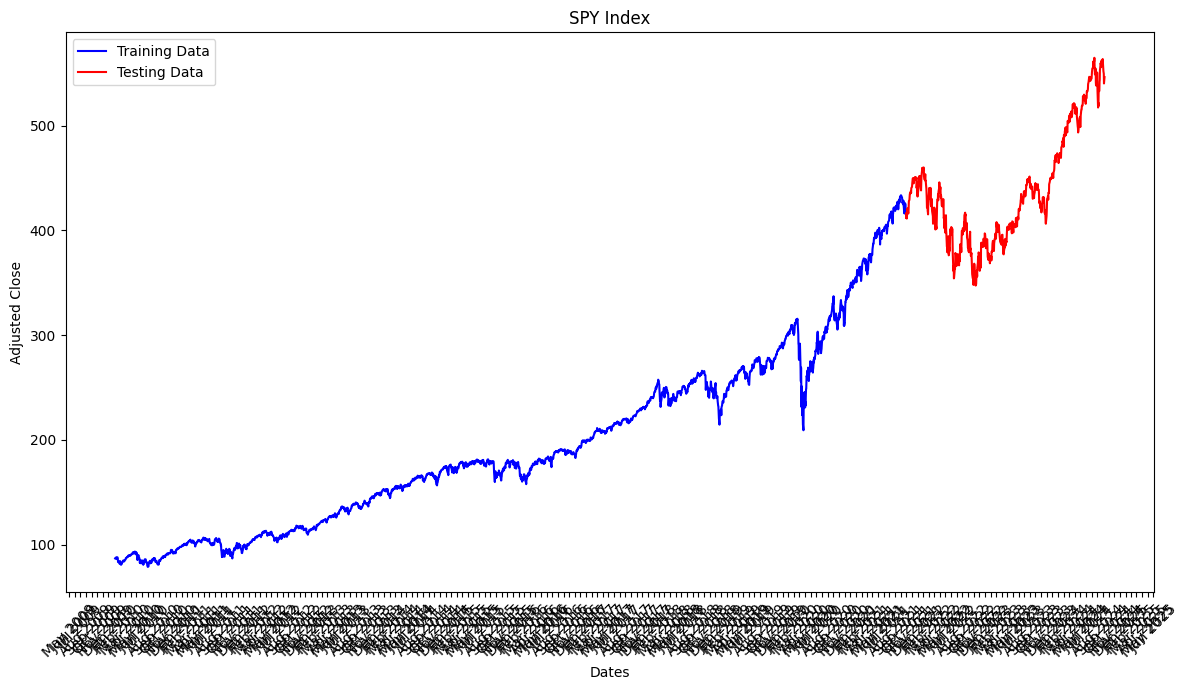

In [235]:
#Splitting in 80:20 Ratio
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]

train_data = train_data.set_index(train_data['Date'], drop= False)
test_data = test_data.set_index(test_data['Date'], drop= False)

plt.figure(figsize=(12,7))
plt.title('SPY Index')
plt.xlabel('Dates')
plt.ylabel('Adjusted Close')
plt.plot(train_data['Adj_Close'], 'blue', label='Training Data')
plt.plot(test_data['Adj_Close'], 'red', label='Testing Data')

# Formatting the x-axis to show month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set locator to every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format to Month Year

# Rotate the x-ticks for better readability
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


# Modeling

The ML Models used here are selected based on the production requirement. We want to deploy the model. As we know that time series model needs to be trained everytime in production with the new data points for accurate prediction so we will be using only those models which have low time complexity in training i.e. which trains faster with new data.

In [236]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [237]:
ts = data['Adj_Close']
ts_diff = data['Differenced_Adj_Close']

In [238]:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [ ]:


plt.figure(figsize=(15,7))

#Plot ACF: 
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')


### ACF and PACF Explanation:

1. **Autocorrelation Function (ACF):** This plot shows how correlated a current observation is with past observations at different lags. Significant autocorrelation at a particular lag indicates that past values at that lag are useful for predicting the current value.

2. **Partial Autocorrelation Function (PACF):** This plot measures the correlation between the current observation and a lagged observation, removing the effect of any intermediary lags. The PACF helps identify the direct impact of a lag without interference from shorter-term dependencies.

- **X-axis (Lag):** Represents the number of time steps back.
- **Y-axis (Autocorrelation/Partial Autocorrelation):** Measures the strength of the correlation. Values closer to 1 or -1 indicate stronger correlations, while values near 0 indicate no correlation.
- **Dashed lines:** Represent the 95% confidence interval. If a value falls outside these lines, it is considered statistically significant.

### Interpreting Points that Cross the Confidence Intervals:

1. **Autocorrelation Function (ACF) Plot:**
   - When a point crosses the dashed confidence intervals, it indicates a statistically significant correlation at that particular lag.
   - The first lag where the ACF crosses the confidence interval helps us determine the **q** (moving average) term for ARIMA modeling.

2. **Partial Autocorrelation Function (PACF) Plot:**
   - Similar to the ACF, points that cross the confidence intervals in the PACF plot represent significant correlations at that lag.
   - The first lag where the PACF crosses the confidence interval helps us determine the **p** (autoregressive) term for ARIMA modeling.

- **p (autoregressive term):** Determined from the PACF plot, representing the number of AR terms needed.
- **q (moving average term):** Determined from the ACF plot, representing the number of MA terms needed.

#### Applying the ARIMA model
This cell fits an ARIMA (AutoRegressive Integrated Moving Average) model to the training data to make predictions. ARIMA is used for time-series forecasting.

**Steps:**
- Fit the model to the training data.
- Use the model to forecast the stock prices on the test set.


In [ ]:
# Train ARIMA Model
# -------------------------
# Fit the ARIMA model to the training data (using adjusted close price as univariate)
print("\nTraining ARIMA Model...")
model = ARIMA(ts_diff, order=(2, 1, 2))
results_ARIMA = model.fit()

plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))


print(results_ARIMA.summary())


In [ ]:
# Predict on training data
# Use the predict method to forecast the train data range
yhat_train = results_ARIMA.predict(1, len(train_data) - 1)

# Reverse differencing to get predicted values back to original scale
predictions_ARIMA_diff_cumsum = yhat_train.cumsum() + train_data['Adj_Close'].iloc[0]

# Create a DataFrame for the predictions and align it with the train data index
# Adjust index to match the number of predictions
predictions = pd.DataFrame(predictions_ARIMA_diff_cumsum.values)
predictions.set_index(train_data.index[1:], inplace=True)  # Align index, as predict starts at 1

# Plot the actual vs predicted values
plt.figure(figsize=(12, 7))
plt.plot(train_data['Adj_Close'][1:], label='Train Data')  # Use training data from index 1 onwards
plt.plot(predictions, label='Predicted Values', color='red')
plt.title('ARIMA Prediction on Train Data')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Calculate RMSE for the training data prediction
RMSE_ARIMA = sqrt(mean_squared_error(train_data['Adj_Close'][1:].values, predictions.values))
print(f"RMSE_ARIMA = {RMSE_ARIMA}")

#### Applying the SARIMAX model
This cell fits a SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model to the training data. SARIMAX is used for forecasting time series with seasonal components.


In [ ]:
model = sm.tsa.statespace.SARIMAX(ts_diff, order=(2, 1, 2), seasonal_order=(1,1,1,12))
results_SARIMAX = model.fit()

print(results_SARIMAX.summary())


In [ ]:
# Predicting the test data period using SARIMAX
yhat_diff = results_SARIMAX.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Reverse differencing to get back to the original scale
# Start the reverse differencing from the last known value of 'Adj_Close' from train data
last_train_adj_close = train_data['Adj_Close'].iloc[-1]
predictions_SARIMAX_diff_cumsum = yhat_diff.cumsum() + last_train_adj_close


print (predictions_SARIMAX_diff_cumsum.head())
print (predictions_SARIMAX_diff_cumsum.tail())

In [ ]:
yhat

predictions = pd.DataFrame(predictions_SARIMAX_diff_cumsum)
predictions.set_index(test_data.index, inplace = True)

plt.figure(figsize=(12,7))

plt.plot(train_data['Adj_Close'], label='Train Data')
plt.plot(test_data['Adj_Close'], label='Test Data')
plt.plot(predictions, label='Predicted Values', color='red')
plt.title('SARIMAX Prediction')
plt.xlabel('Years')
plt.ylabel('Adjusted Close Price')
plt.legend()

# Evaluate RMSE on original scale
RMSE_SARIMAX = sqrt(mean_squared_error(test_data['Adj_Close'].values, predictions_SARIMAX_diff_cumsum.values))
print(f"RMSE_SARIMAX = {RMSE_SARIMAX}")


#### Applying the Prophet model
This cell uses the Facebook Prophet model for time-series forecasting. Prophet is used for capturing seasonality in time-series data.

**Steps:**
- Fit the Prophet model to the training data.
- Forecast stock prices for the test set.


19:16:24 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing


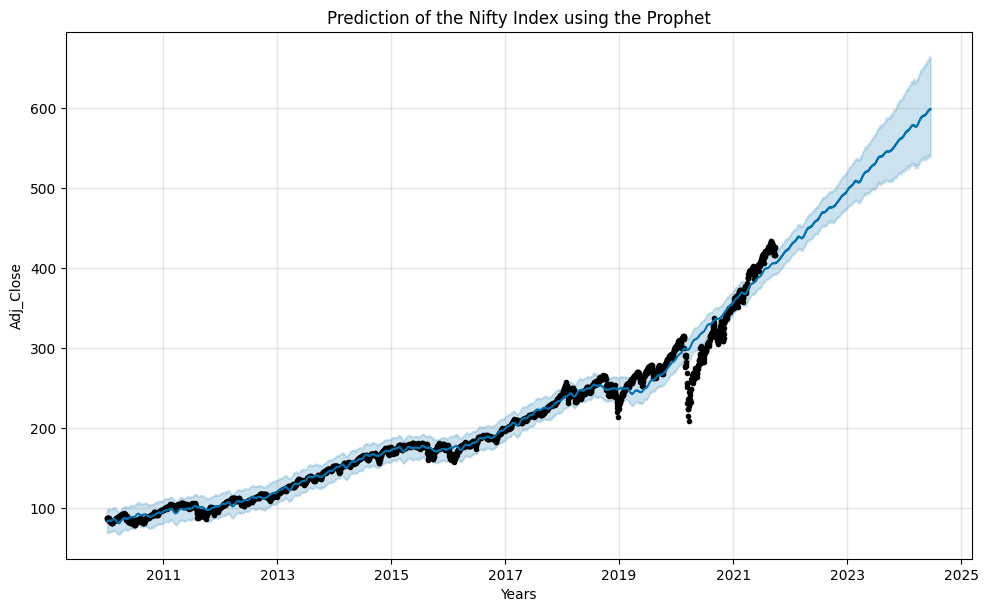

In [240]:
#Train Facebook Prophet Model
# ------------------------------------
# Rename the features: These names are NEEDED for the model fitting
ts = train_data.rename(columns = {"Date":"ds","Adj_Close":"y"})

m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(ts) # fit the model using all data

future = m.make_future_dataframe(periods=994) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)

plt.title("Prediction of the SPY using the Prophet")
plt.xlabel("Years")
plt.ylabel("Adj_Close")
plt.show()

In [245]:
yhat = prediction['yhat'].tail(len(test_data))

RMSE_Prophet = 98.90262120032587


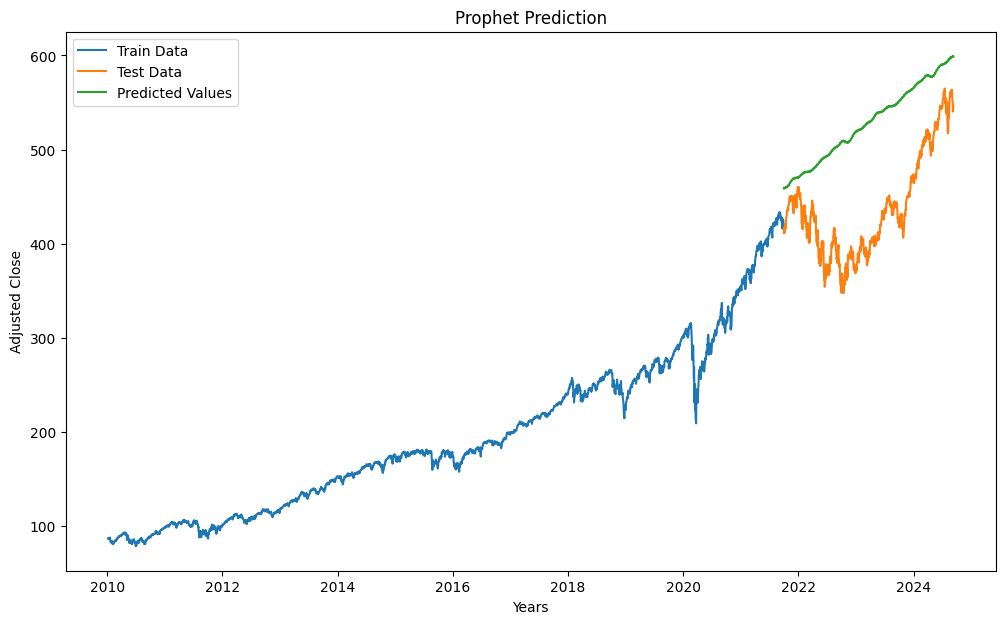

In [247]:
predictions = pd.DataFrame(yhat)
predictions.set_index(test_data.index, inplace = True)

plt.figure(figsize=(12,7))

plt.plot(train_data['Adj_Close'], label = 'Train Data')
plt.plot(test_data['Adj_Close'], label = 'Test Data')
plt.plot(predictions, label = 'Predicted Values')
plt.title('Prophet Prediction')
plt.xlabel('Years')
plt.ylabel('Adjusted Close')
plt.legend()

RMSE_Prophet = sqrt(mean_squared_error(test_data['Adj_Close'].values, yhat))

print(f"RMSE_Prophet = {RMSE_Prophet}")


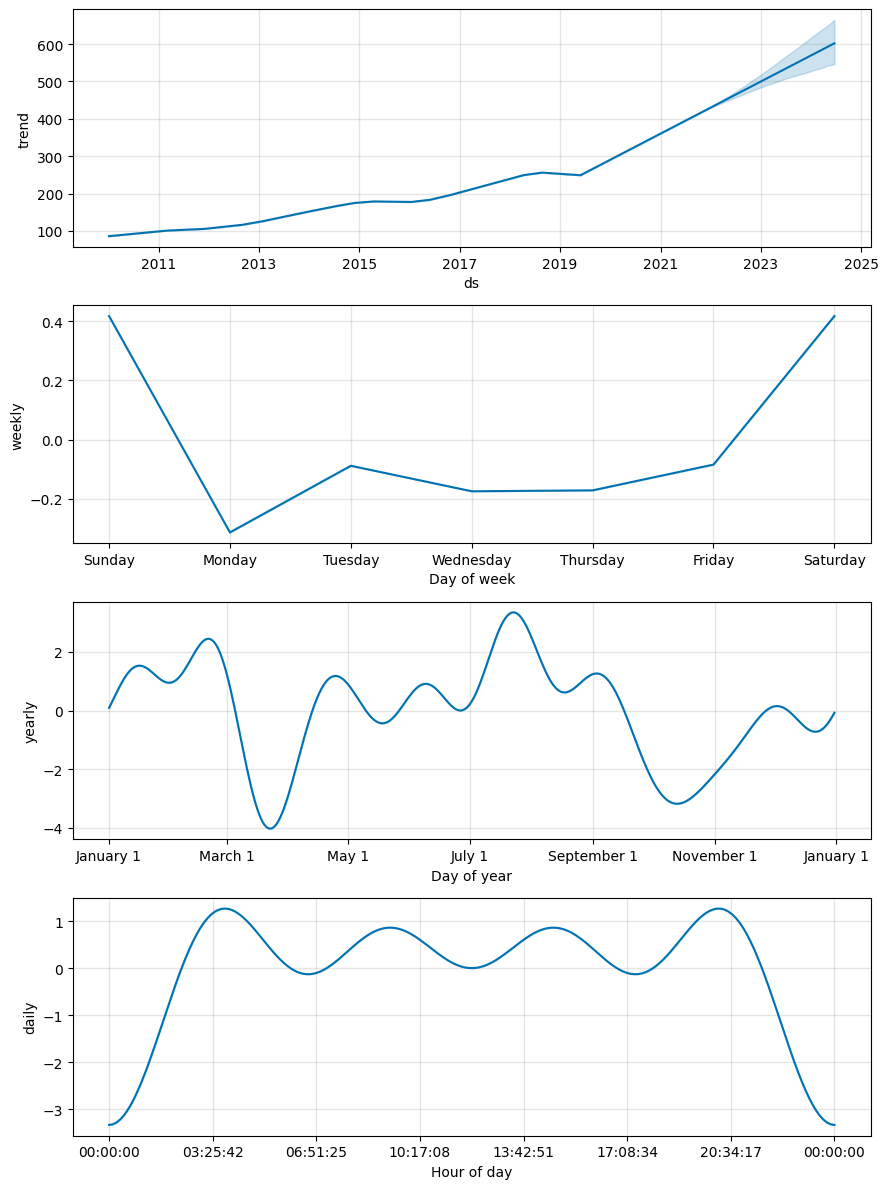

In [248]:
m.plot_components(prediction)
plt.show()


Our data has some seasonal information present. This is why SARIMAX also performed well.

Following points can be observed from the above graphs:

Our data shows an upward trend.
Stock price gets up on saturday and remains almost flat during weekdays.
There is high chance to observe 52 week low Stock Price in the February End- Late April period.
Stock Price fluctuates during the whole day.

# LSTM

In [ ]:
# Feature Scaling
scaler = MinMaxScaler()
training_set_scaled = scaler.fit_transform(X_train.values.reshape(-1, 1))
cv_set_scaled = scaler.transform(X_cv.values.reshape(-1, 1))
test_set_scaled = scaler.transform(X_test.values.reshape(-1, 1))

# Creating Dataset with Window Size 30
def create_dataset(dataset, look_back=30):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i+look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Prepare LSTM Sequences
X_train_lstm, y_train_lstm = create_dataset(training_set_scaled, 30)
X_cv_lstm, y_cv_lstm = create_dataset(cv_set_scaled, 30)
X_test_lstm, y_test_lstm = create_dataset(test_set_scaled, 30)

# Reshape data to 3D for LSTM [samples, time_steps, features]
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_cv_lstm = np.reshape(X_cv_lstm, (X_cv_lstm.shape[0], X_cv_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Define RMSE as the loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Build the LSTM Model
model = models.Sequential()
model.add(layers.LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1))

# Compile the LSTM model with RMSE as the loss function
model.compile(optimizer='adam', loss=root_mean_squared_error)

# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model with training and CV data
model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_cv_lstm, y_cv_lstm), callbacks=[early_stopping])

# Predict on the test data
y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)  # Rescale back to original values

# Evaluate with RMSE
rmse_lstm = rmse(y_test_lstm, y_pred_lstm)
print(f"LSTM Model RMSE: {rmse_lstm}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_dates, X_train, color='blue', label='Train Data')
plt.plot(test_dates, y_test, color='orange', label='Test Data')
plt.plot(test_dates[-len(y_pred_lstm):], y_pred_lstm, color='green', label='Predicted Data')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



In [ ]:
# Evaluate All Models and Compare
# ---------------------------------------
# Ensure you have the 'Date' column in the test set for plotting

test_dates = data['Date'].iloc[-len(y_test):]  # Get the corresponding dates for the test set

plt.figure(figsize=(15, 10))

# ARIMA
plt.subplot(2, 2, 1)
plt.plot(test_dates, y_test.values, label='Actual')
plt.plot(test_dates, y_pred_arima, label='Predicted', linestyle='--')
plt.title('ARIMA: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# SARIMAX
plt.subplot(2, 2, 2)
plt.plot(test_dates, y_test.values, label='Actual')
plt.plot(test_dates, y_pred_sarimax, label='Predicted', linestyle='--')
plt.title('SARIMAX: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# Prophet
plt.subplot(2, 2, 3)
plt.plot(test_dates, y_test.values, label='Actual')
plt.plot(test_dates, y_pred_prophet, label='Predicted', linestyle='--')
plt.title('Prophet: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# LSTM
plt.subplot(2, 2, 4)
plt.plot(test_dates[-len(y_pred_lstm):], y_test.values[-len(y_pred_lstm):], label='Actual')
plt.plot(test_dates[-len(y_pred_lstm):], y_pred_lstm, label='Predicted', linestyle='--')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def reverse_differencing(differenced_data, original_data, column):
    """
    Reverse differencing to get back to the original scale of the time series.
    
    Parameters:
    differenced_data (pd.Series): The predicted differenced time series (e.g., model output).
    original_data (pd.Series): The original time series before differencing (used for reference).
    column (str): The column name of the original time series.
    
    Returns:
    pd.Series: The time series restored to the original scale.
    """
    # Reverse differencing: Add back the previous original value to the differenced series
    undifferenced = [original_data.iloc[0]]  # The first value (used as a reference point)

    for i in range(1, len(differenced_data)):
        undifferenced.append(differenced_data.iloc[i] + undifferenced[i-1])

    return pd.Series(undifferenced)

In [ ]:
import matplotlib.dates as mdates

# Step 1: Get the actual values before differencing
# Assuming 'data' contains the original time series and 'y_test' is the differenced test set
original_test_data = data['Adj_Close'].iloc[-len(y_test):]  # Get the original test data

# Step 2: Reverse differencing for each model's predicted results
# For example, reverse differencing for the LSTM model
y_pred_lstm_undiff = reverse_differencing(pd.Series(y_pred_lstm.flatten()), original_test_data, 'Adj_Close')
y_pred_arima_undiff = reverse_differencing(pd.Series(y_pred_arima), original_test_data, 'Adj_Close')
y_pred_sarimax_undiff = reverse_differencing(pd.Series(y_pred_sarimax), original_test_data, 'Adj_Close')
y_pred_prophet_undiff = reverse_differencing(pd.Series(y_pred_prophet), original_test_data, 'Adj_Close')

# Step 3: Align test_dates with the length of each prediction
test_dates_lstm = pd.to_datetime(test_dates[-len(y_pred_lstm_undiff):])
test_dates_arima = pd.to_datetime(test_dates[-len(y_pred_arima_undiff):])
test_dates_sarimax = pd.to_datetime(test_dates[-len(y_pred_sarimax_undiff):])
test_dates_prophet = pd.to_datetime(test_dates[-len(y_pred_prophet_undiff):])

# Step 4: Get training data (before the test set)
train_data = data['Adj_Close'].iloc[:-len(y_test)]  # Get all rows before the test set
train_dates = pd.to_datetime(data['Date'].iloc[:-len(y_test)])  # Corresponding dates for the training data

# Step 5: Plot Training, Test, and Predicted Data
plt.figure(figsize=(15, 10))

# LSTM
plt.subplot(2, 2, 1)
plt.plot(train_dates, train_data, label='Train Data', color='blue')  # Plot training data
plt.plot(test_dates_lstm, original_test_data[-len(y_pred_lstm_undiff):].values, label='Test Data', color='green')  # Plot test data
plt.plot(test_dates_lstm, y_pred_lstm_undiff, label='Predicted Data', linestyle='--', color='orange')  # Plot predictions
plt.title('LSTM: Train, Test, and Predicted Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# ARIMA
plt.subplot(2, 2, 2)
plt.plot(train_dates, train_data, label='Train Data', color='blue')
plt.plot(test_dates_arima, original_test_data[-len(y_pred_arima_undiff):].values, label='Test Data', color='green')
plt.plot(test_dates_arima, y_pred_arima_undiff, label='Predicted Data', linestyle='--', color='orange')
plt.title('ARIMA: Train, Test, and Predicted Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# SARIMAX
plt.subplot(2, 2, 3)
plt.plot(train_dates, train_data, label='Train Data', color='blue')
plt.plot(test_dates_sarimax, original_test_data[-len(y_pred_sarimax_undiff):].values, label='Test Data', color='green')
plt.plot(test_dates_sarimax, y_pred_sarimax_undiff, label='Predicted Data', linestyle='--', color='orange')
plt.title('SARIMAX: Train, Test, and Predicted Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# Prophet
plt.subplot(2, 2, 4)
plt.plot(train_dates, train_data, label='Train Data', color='blue')
plt.plot(test_dates_prophet, original_test_data[-len(y_pred_prophet_undiff):].values, label='Test Data', color='green')
plt.plot(test_dates_prophet, y_pred_prophet_undiff, label='Predicted Data', linestyle='--', color='orange')
plt.title('Prophet: Train, Test, and Predicted Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# Step 6: Apply date formatting for all subplots
for ax in plt.gcf().get_axes():
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show the 1st of each month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as Month Year
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=30))  # Optional minor ticks
    ax.grid(True)

plt.tight_layout()
plt.show()
